# Notebook 1 - Basic Exploration & Logistic Regression Baseline

In [4]:
%matplotlib inline

import os

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
import spacy

## Data Ingestion

In [5]:
BASEDIR = '/data/datasets/kaggle/jigsaw-toxic-comment-classification-challenge'

Let's first inspect the training set and gather basic metrics

In [6]:
train = pd.read_csv(os.path.join(BASEDIR, 'train.csv'))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [7]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(395.34186393464859, 595.10207169971216, 5000)

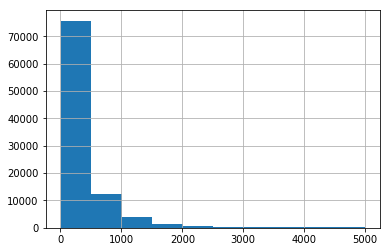

In [8]:
lens.hist();

In [9]:
test = pd.read_csv(os.path.join(BASEDIR, 'test.csv'))
test.head()

,id,comment_text
0,6044863,==Orphaned non-free media (Image:41cD1jboEvL. ...
1,6102620,::Kentuckiana is colloquial. Even though the ...
2,14563293,"Hello fellow Wikipedians,\nI have just modifie..."
3,21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
4,22982444,== [WIKI_LINK: Talk:Celts] ==


In [10]:
train['comment_text'] = train['comment_text'].fillna(' ')
test['comment_text'] = test['comment_text'].fillna(' ')

In [11]:
submission = pd.read_csv(os.path.join(BASEDIR, 'sample_submission.csv'))
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.5,0.5,0.5,0.5,0.5,0.5
1,6102620,0.5,0.5,0.5,0.5,0.5,0.5
2,14563293,0.5,0.5,0.5,0.5,0.5,0.5
3,21086297,0.5,0.5,0.5,0.5,0.5,0.5
4,22982444,0.5,0.5,0.5,0.5,0.5,0.5


## Basic analysis
This is a multilabel classification task, so let's check the proportion of each label:

In [12]:
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print(label, (train[label] == 1.0).sum() / len(train))

toxic 0.0963683216659
severe_toxic 0.0100677092571
obscene 0.0533014783362
threat 0.0031820220968
insult 0.0497125747254
identity_hate 0.00849234749768


In [13]:
train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308810,0.677491,0.162967,0.648330,0.259124
severe_toxic,0.308810,1.000000,0.404540,0.133469,0.377450,0.193385
obscene,0.677491,0.404540,1.000000,0.149874,0.744685,0.287794
threat,0.162967,0.133469,0.149874,1.000000,0.157534,0.123971
insult,0.648330,0.377450,0.744685,0.157534,1.000000,0.331922
identity_hate,0.259124,0.193385,0.287794,0.123971,0.331922,1.000000


In [14]:
token_counts = CountVectorizer(
    strip_accents='unicode',
    analyzer='word',
    lowercase=True,
    ngram_range=(1,1),
    token_pattern=r'\w{2,}',
    max_features=30000)
token_counts.fit(train['comment_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents='unicode', token_pattern='\\w{2,}', tokenizer=None,
        vocabulary=None)

In [15]:
X = token_counts.fit_transform(train['comment_text'])

In [16]:
token_freq = X.sum(axis=0).tolist()[0]
token_freq[:5]

[484, 1160, 92, 12, 13]

In [17]:
token_counts_list = [(k, token_freq[v]) for k, v in token_counts.vocabulary_.items()]
token_counts_list = sorted(token_counts_list, key=lambda x: x[1], reverse=True)

In [18]:
token_counts_list[:25]

[('the', 298519),
 ('to', 178473),
 ('of', 135159),
 ('and', 134598),
 ('you', 132255),
 ('is', 106191),
 ('that', 97203),
 ('it', 89201),
 ('in', 87442),
 ('for', 61943),
 ('this', 58655),
 ('not', 56674),
 ('on', 54089),
 ('be', 50228),
 ('as', 46431),
 ('are', 44062),
 ('have', 43460),
 ('your', 37761),
 ('with', 36144),
 ('if', 35336),
 ('article', 34410),
 ('was', 32727),
 ('or', 32474),
 ('but', 30546),
 ('wikipedia', 29250)]

In [19]:
token_counts_list[-25:]

[('vbe', 5),
 ('ohinternet', 5),
 ('opec', 5),
 ('zj', 5),
 ('orkhon', 5),
 ('harawira', 5),
 ('nomme', 5),
 ('mikenorton', 5),
 ('catt', 5),
 ('primrose', 5),
 ('hue', 5),
 ('babli', 5),
 ('sparxent', 5),
 ('prsa', 5),
 ('pietruczuk', 5),
 ('rasche', 5),
 ('heiemo', 5),
 ('lra', 5),
 ('corpsefucking', 5),
 ('tielu', 5),
 ('matthewfenton', 5),
 ('miquonranger03', 5),
 ('vcite', 5),
 ('cozette', 5),
 ('dwpaul', 5)]

## Text Preprocessing

In [20]:
sample_train = train[:100]

In [21]:
nlp = spacy.load('en', disable=['parser', 'ner', 'textcat'])

In [22]:
def reduce_to_double_max(text):
    """Removes unecessary doubling/tripling/etc of characters
    
    Steps:
        1. Replaces every 3+ consecutive identical chars by 2 consecutive identical chars
        2. Replaces every 2+ consecutive non-word character by a single
    """
    import re
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    return re.sub(r'(\W)\1+', r'\1', text)

In [23]:
def preprocess_corpus(corpus):
    """Applies all preprocessing rules to the corpus"""
    corpus = (reduce_to_double_max(s.lower()) for s in corpus)
    docs = nlp.pipe(corpus, batch_size=1000, n_threads=12)
    return [' '.join([x.lemma_ for x in doc if x.is_alpha]) for doc in docs]

In [24]:
sample_train['comment_text_processed'] = preprocess_corpus(sample_train['comment_text'])

/home/iceman/.pyenv/versions/3.6.2/envs/toxic/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
sample_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_processed
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,nonsense kiss off geek what i say be true -PRO...
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0,please do not vandalize page as -PRON- do with...
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0,point of interest i remove the point of intere...
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0,ask some -PRON- nationality be a racial offenc...
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0,the reader here be not go by -PRON- say so for...


In [26]:
fname_train_processed = '../data/processed/train.txt'

if os.path.isfile(fname_train_processed):
    with open(fname_train_processed, 'r') as fin:
        train_processed = [line.strip() for line in fin if line]
    
else:
    train_processed = preprocess_corpus(train['comment_text'])

    with open(fname_train_processed, 'w') as fout:
        for doc in train_processed:
            fout.write('{}\n'.format(doc))
    
train['comment_text_processed'] = train_processed

In [27]:
fname_test_processed = '../data/processed/test.txt'

if os.path.isfile(fname_test_processed):
    with open(fname_test_processed, 'r') as fin:
        test_processed = [line.strip() for line in fin if line]
    
else:
    test_processed = preprocess_corpus(test['comment_text'])

    with open(fname_test_processed, 'w') as fout:
        for doc in test_processed:
            fout.write('{}\n'.format(doc))
    
test['comment_text_processed'] = test_processed

## Train & Validation

In [28]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [29]:
all_text = pd.concat([train['comment_text_processed'], test['comment_text_processed']])

In [30]:
word_vect = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{2,}',
    ngram_range=(1,2),
    max_features=100000,
    binary=True)
word_vect.fit(all_text)

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{2,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [31]:
train_word_features = word_vect.transform(train['comment_text_processed'])
test_word_features = word_vect.transform(test['comment_text_processed'])

In [32]:
char_vect = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1,4),
    max_features=50000)
char_vect.fit(all_text)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 4), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [33]:
train_char_features = char_vect.transform(train['comment_text_processed'])
test_char_features = char_vect.transform(test['comment_text_processed'])

In [34]:
train_features = hstack((train_char_features, train_word_features))
test_features = hstack((test_char_features, test_word_features))

In [35]:
def evaluate_model(model, y_true, train_ft):
    cv_loss = np.mean(cross_val_score(model, train_ft, y_true, cv=3, n_jobs=4, scoring='neg_log_loss'))
    return cv_loss

In [36]:
losses = []
preds = {'id': test['id']}
for class_name in class_names:
    targets = train[class_name]
    model = LogisticRegression(C=4.5, solver='sag')
    loss = evaluate_model(model, targets, train_features)
    print('Avg. CV loss for class {}: {}'.format(class_name, loss))
    losses.append(loss)
    model.fit(train_features, targets)
    preds[class_name] = model.predict_proba(test_features)[:, 1]

Avg. CV loss for class toxic: -0.10742453692283375
Avg. CV loss for class severe_toxic: -0.02735634377924882
Avg. CV loss for class obscene: -0.05859598700532948


/home/iceman/.pyenv/versions/3.6.2/envs/toxic/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/iceman/.pyenv/versions/3.6.2/envs/toxic/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/iceman/.pyenv/versions/3.6.2/envs/toxic/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Avg. CV loss for class threat: -0.010322841418776043


/home/iceman/.pyenv/versions/3.6.2/envs/toxic/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Avg. CV loss for class insult: -0.07822685518477351
Avg. CV loss for class identity_hate: -0.024816074351928202


In [37]:
print('Cumulative Avg. CV loss: {}'.format(np.mean(losses)))

Cumulative Avg. CV loss: -0.05112377311048164


## Submission

In [38]:
submission = pd.DataFrame.from_dict(preds)

In [39]:
import time
submission.to_csv('../data/external/submission-{}.csv'.format(time.strftime('%Y%m%d_%H%M', time.localtime())), index=False)